In [33]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile
import seaborn as sns

**READING IN KINESSO DATA**

In [34]:
imp = pd.read_csv('impressions_one_hour.csv')
imp = imp[imp['country'] == 'Germany']
imp = imp[~imp['zip_code'].isna()]
imp['zip_code'] = imp['zip_code'].astype(str)

**READING IN 2011 GERMANY CENSUS DATA**

In [35]:
# data from: https://www.suche-postleitzahl.org/downloads
zip_codes = pd.read_csv("plz_einwohner.csv")


In [36]:
def add_zero(x):
    if len(x) == 4:
        return '0'+ x
    else:
        return x

**CORRECTING FORMATTING ERROR THAT REMOVED INITIAL '0' FROM ZIPCODES**

In [37]:
zip_codes['zipcode'] = zip_codes['zipcode'].astype(str).apply(add_zero)
zip_codes.head()

,zipcode,population
0,01067,11957
1,01069,25491
2,01097,14811
3,01099,28021
4,01108,5876


Real Population of Germany is 83.02 million

In [38]:
np.sum(zip_codes['population'])

80322251

**CALCULATING VALUE COUNTS FROM KINESSO DATA**

In [39]:
val_cou = imp['zip_code'].value_counts()
val_counts = pd.DataFrame(columns=['zipcode', 'count'], data=val_cou)
val_counts['zipcode'] = val_cou.index.astype(str)
val_counts['count'] = val_cou.values.astype(int)
val_counts

,zipcode,count
0,80796,1128
1,50676,245
2,60326,232
3,20099,215
4,44137,187
...,...,...
4687,27639,1
4688,25774,1
4689,89331,1
4690,39624,1


**MERGING TOGETHER KINESSO VALUE COUNTS WITH KINESSO DATA**


*ONLY 19 ZIPCODES DO NOT HAVE CENSUS DATA*

In [40]:
population_count = val_counts.merge(right=zip_codes, right_on='zipcode', left_on='zipcode', how='outer')
population_count_f = population_count.dropna()

In [41]:
#only 19 zipcodes without data
len(population_count[population_count['population'].isna()])

19

Here count is the observed number from the Kinesso dataset and population is the expected number from census dataset

In [42]:
population_count_f

,zipcode,count,population
0,80796,1128.0,15424.0
1,50676,245.0,14676.0
2,60326,232.0,20809.0
3,20099,215.0,9050.0
4,44137,187.0,21573.0
...,...,...,...
4687,27639,1.0,17093.0
4688,25774,1.0,4172.0
4689,89331,1.0,9323.0
4690,39624,1.0,8126.0


**CALCULATING DEVICE FREQUENCIES FOR EACH ZIPCODE**

In [43]:
imp['count'] = [1] * len(imp)
device_model_make_counts = imp.groupby(['zip_code', 'device_make', 'device_model'], as_index=False).count()[['zip_code', 'device_make', 'device_model', 'count']]
total_calc = device_model_make_counts.groupby(['zip_code']).sum()


In [44]:
percent_calc = []
for i in device_model_make_counts.index:
    zipc = device_model_make_counts.iloc[i]['zip_code']
    percent_calc = np.append(percent_calc, device_model_make_counts.iloc[i]['count']/total_calc.loc[zipc])

In [45]:
device_model_make_counts['device % freq']= percent_calc *100
device_model_make_counts['combined'] = device_model_make_counts['device_make'] + ' ' + device_model_make_counts['device_model']
device_model_make_counts['zip_code'] = device_model_make_counts['zip_code'].astype(str).apply(add_zero)
device_model_make_counts
 

,zip_code,device_make,device_model,count,device % freq,combined
0,01067,Lenovo,YT-X705F,1,50.000000,Lenovo YT-X705F
1,01067,Samsung,SM-J510FN,1,50.000000,Samsung SM-J510FN
2,01069,Apple,iPhone,1,11.111111,Apple iPhone
3,01069,Huawei,CLT-L29,1,11.111111,Huawei CLT-L29
4,01069,Huawei,JSN-L21,1,11.111111,Huawei JSN-L21
...,...,...,...,...,...,...
27520,99986,Samsung,SM-A715F,1,14.285714,Samsung SM-A715F
27521,99986,Samsung,SM-G950F,1,14.285714,Samsung SM-G950F
27522,99986,Samsung,SM-J710F,1,14.285714,Samsung SM-J710F
27523,99988,Samsung,SM-A750FN,1,100.000000,Samsung SM-A750FN


**CALCULATING PERCENT DIFFERENCE BETWEEN EXPECTED AND OBSERVED POPULATIONS FOR EACH ZIPCODE**

In [46]:
population_count_f['population % expected'] = (population_count_f['population']/sum(population_count_f['population']))*100
population_count_f['population % observed'] = (population_count_f['count']/sum(population_count_f['count']))*100
population_count_f['% difference'] = population_count_f['population % observed'] - population_count_f['population % expected']
population_count_f = population_count_f.rename(columns={'count':'observed population', 'population':'expected population'})
population_count_f

<ipython-input-46-cfa73adf08fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_count_f['population % expected'] = (population_count_f['population']/sum(population_count_f['population']))*100
<ipython-input-46-cfa73adf08fd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  population_count_f['population % observed'] = (population_count_f['count']/sum(population_count_f['count']))*100
<ipython-input-46-cfa73adf08fd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

,zipcode,observed population,expected population,population % expected,population % observed,% difference
0,80796,1128.0,15424.0,0.023805,2.981130,2.957325
1,50676,245.0,14676.0,0.022650,0.647497,0.624847
2,60326,232.0,20809.0,0.032116,0.613140,0.581025
3,20099,215.0,9050.0,0.013967,0.568212,0.554244
4,44137,187.0,21573.0,0.033295,0.494212,0.460917
...,...,...,...,...,...,...
4687,27639,1.0,17093.0,0.026381,0.002643,-0.023738
4688,25774,1.0,4172.0,0.006439,0.002643,-0.003796
4689,89331,1.0,9323.0,0.014389,0.002643,-0.011746
4690,39624,1.0,8126.0,0.012541,0.002643,-0.009898


*MERGING TOGETHER WITH DEVICE FREQUENCY DATA*

In [47]:
combo = device_model_make_counts.merge(right=population_count_f, right_on='zipcode', left_on='zip_code', how='outer').drop(['count', 'device_make', 'device_model'], axis=1)
combined_impressions = combo.sort_values('% difference', ascending=False)


In [48]:
combined_impressions

,zip_code,device % freq,combined,zipcode,observed population,expected population,population % expected,population % observed,% difference
23300,80796,0.797872,Huawei EML-L29,80796,1128.0,15424.0,0.023805,2.98113,2.957325
23456,80796,0.088652,Sony E6633,80796,1128.0,15424.0,0.023805,2.98113,2.957325
23448,80796,0.088652,Samsung SM-T595,80796,1128.0,15424.0,0.023805,2.98113,2.957325
23449,80796,0.088652,Samsung SM-T720,80796,1128.0,15424.0,0.023805,2.98113,2.957325
23299,80796,0.088652,Huawei EML-L09,80796,1128.0,15424.0,0.023805,2.98113,2.957325
...,...,...,...,...,...,...,...,...,...
26633,09561,50.000000,Samsung SM-G950F,NaN,NaN,NaN,NaN,NaN,NaN
26987,97412,50.000000,Apple iPhone,NaN,NaN,NaN,NaN,NaN,NaN
26988,97412,50.000000,Samsung SM-T580,NaN,NaN,NaN,NaN,NaN,NaN
27239,98599,100.000000,Samsung SM-G903F,NaN,NaN,NaN,NaN,NaN,NaN


*GROUPING TO IDENTIFY MOST COMMONLY USED DEVICE*

In [49]:
most_common_device = combined_impressions.groupby(['zip_code']).max()
most_common_device

,device % freq,combined,zipcode,observed population,expected population,population % expected,population % observed,% difference
zip_code,,,,,,,,
01067,50.000000,Samsung SM-J510FN,01067,2.0,11957.0,0.018454,0.005286,-0.013168
01069,22.222222,Wiko W K400,01069,9.0,25491.0,0.039342,0.023786,-0.015556
01097,14.285714,ZTE Blade A7 2019,01097,14.0,14811.0,0.022859,0.037000,0.014141
01099,28.571429,Sony H3113,01099,28.0,28021.0,0.043246,0.074000,0.030753
01109,11.111111,Vodafone VFD 600,01109,9.0,20010.0,0.030883,0.023786,-0.007097
...,...,...,...,...,...,...,...,...
99974,11.111111,Samsung SM-N950F,99974,9.0,35948.0,0.055481,0.023786,-0.031695
99976,33.333333,Xiaomi Pocophone F1,99976,3.0,11009.0,0.016991,0.007929,-0.009062
99986,14.285714,Samsung SM-J710F,99986,7.0,6097.0,0.009410,0.018500,0.009090


*IDENTIFYING MOST UNDER REPRESENTED ZIP CODES*

In [50]:
underrepresented = most_common_device.sort_values('% difference').head(1000)
underrepresented.head(10)

,device % freq,combined,zipcode,observed population,expected population,population % expected,population % observed,% difference
zip_code,,,,,,,,
50259,12.500000,Xiaomi M1903F11G,50259,8.0,53025.0,0.081837,0.021143,-0.060694
52134,20.000000,Samsung SM-G975F,52134,5.0,46468.0,0.071717,0.013214,-0.058503
53332,20.000000,Samsung SM-G950F,53332,5.0,46272.0,0.071414,0.013214,-0.058200
52249,30.000000,Samsung SM-G960F,52249,10.0,54732.0,0.084471,0.026428,-0.058043
30419,33.333333,Samsung SM-G973F,30419,3.0,40593.0,0.062650,0.007929,-0.054721
47877,22.222222,Samsung SM-N960F,47877,9.0,50792.0,0.078390,0.023786,-0.054605
41836,33.333333,Samsung SM-G955F,41836,3.0,38969.0,0.060143,0.007929,-0.052215
50321,33.333333,Xiaomi Mi 9 Lite,50321,6.0,43567.0,0.067239,0.015857,-0.051382
53639,25.000000,Samsung SM-T585,53639,4.0,40048.0,0.061808,0.010571,-0.051237


In [57]:
underrepresented['combined'].value_counts()

Apple iPhone         75
Samsung SM-G973F     65
Samsung SM-G960F     46
Samsung SM-G950F     46
Samsung SM-T580      35
                     ..
Samsung SM-T290       1
Wiko U Pulse Lite     1
Umidigi A5 Pro        1
Sony J9110            1
LG LM-G710            1
Name: combined, Length: 267, dtype: int64

*IDENTIFYING MOST OVER REPRESENTED ZIP CODES*

In [53]:
overrepresented = most_common_device.sort_values('% difference', ascending=False).head(1000)
overrepresented.head(10)

,device % freq,combined,zipcode,observed population,expected population,population % expected,population % observed,% difference
zip_code,,,,,,,,
80796,26.950355,cubot King Kong,80796,1128.0,15424.0,0.023805,2.981130,2.957325
50676,20.816327,android generic,50676,245.0,14676.0,0.022650,0.647497,0.624847
60326,18.534483,Xiaomi Redmi Note 8,60326,232.0,20809.0,0.032116,0.613140,0.581025
20099,16.744186,android 8227L_demo,20099,215.0,9050.0,0.013967,0.568212,0.554244
44137,27.807487,ZTE Blade A3 2020,44137,187.0,21573.0,0.033295,0.494212,0.460917
04275,18.497110,cat S60,04275,173.0,22082.0,0.034080,0.457212,0.423132
22085,24.375000,ZTE Blade V0850,22085,160.0,11978.0,0.018486,0.422855,0.404369
10179,15.894040,unknown QuickBox_G47A04_hw,10179,151.0,18664.0,0.028805,0.399070,0.370264
04720,21.153846,ZTE Blade L130,04720,156.0,28916.0,0.044628,0.412284,0.367656


In [58]:
overrepresented['combined'].value_counts()

Xiaomi Note 8 Pro     51
Samsung SM-T580       39
Samsung SM-G973F      24
Xiaomi Note 7         22
Xiaomi Mi 9T          17
                      ..
oukitel K10000 Pro     1
Xiaomi Redmi 8A        1
Wiko Lenny 4 Plus      1
Sony XQ-AD52           1
Samsung SM-N915FY      1
Name: combined, Length: 304, dtype: int64

**I actually decided not to look to closely into the device frequency numbers because for the underrepresented zipcodes there's only like 8-9 people Kinesso advertised to-- and mostly to Apple users interestingly. Instead I did some digging into the top 10 and bottom 10 in a seperate google docs titled: top 10 zipcode investigation** 

*quick summary: 

**over represented** zip codes belong to large urban cities with more industries and probably higher incomes but idk because I couldn't find zip code specific salary data

**under represented:** zip codes belong to small cities with industries like coal, tourism, and power plants. Also I suspect lower incomes, but idk for sure

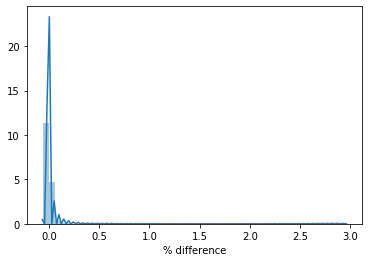

In [56]:
sns.distplot(most_common_device['% difference'])